In [1]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="whitegrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [9]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn import selection
from tools.sklearn.vectorizers import FreqVectorizer

FIT_MODEL = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


# Modeling
## Loading the Data

In [4]:
# Load training data
df = pd.read_parquet("data/model_data", engine="pyarrow")

# Shuffle for good measure
df = df.sample(frac=1, random_state=68)

df.head()

text  \
asin                                                            
B000I7977C  intel cpu pentium mobile core_duo tray enable ...   
B000L697N4  kitchenaid cooks series piece cutlery block_se...   
B00KWTSVC8  niceeshop_tm mini silicone lotus_flower cake m...   
B0058NN4QG  pilot parallel pen_ink refills calligraphy pen...   
B00DMA5V36  arm_bushing rear control_arm toyota febest_feb...   

                                                        title       brand  \
asin                                                                        
B000I7977C  intel cpu pentium mobile t7200 2.0ghz fsb667mh...       intel   
B000L697N4  kitchenaid cooks series 14-piece cutlery block...  kitchenaid   
B00KWTSVC8  niceeshop(tm) mini silicone lotus flower cake ...   niceeshop   
B0058NN4QG  pilot parallel pen ink refills for calligraphy...       pilot   
B00DMA5V36  4872528050 - arm bushing (for rear control arm...      febest   

           lang         main_cat  
asin                              
B000I7977C   en  all electronics  
B000L697N4   en      amazon home  
B00KWTSVC8   en      amazon home  
B0058NN4QG   en  office products  
B00DMA5V36   en       automotive

<IPython.core.display.Javascript object>

In [6]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X.shape, y.shape

((1070668,), (1070668,))

<IPython.core.display.Javascript object>

In [5]:
pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [7]:
def extract_coef(
    pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Refitting the Model

Next I refit the model on the full `X`.

In [10]:
if FIT_MODEL:
    # Train on full X
    pipe.fit(X, y)
    joblib.dump(pipe, "models/final_refit.joblib", compress=True)

else:
    # Load the saved model
    pipe = joblib.load("models/final_refit.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.6min
[Pipeline] ............... (step 2 of 2) Processing cls, total=14.9min


Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [15]:
len(pipe["vec"].get_feature_names())

577793

<IPython.core.display.Javascript object>

In [25]:
coef = extract_coef(pipe)
coef = coef.sort_values("video games", ascending=False)
coef.head(10)

all beauty  all electronics  amazon devices  \
cta_digital                  -0.044039        -1.478603       -0.410506   
electronic_arts              -0.023220        -0.585648        0.000000   
ubisoft                      -0.040663        -0.425397       -0.010356   
activision                   -0.021276        -0.306994       -0.132854   
mad_catz                     -0.009422        -1.744171       -0.021155   
atari                        -0.075942        -0.375346        0.000000   
nintendo                     -0.522385        -1.463506       -1.569281   
sega                         -0.050741        -0.548113       -0.018210   
thq                          -0.082338        -0.240598        0.000000   
disney_interactive_studios    0.000000        -0.084691        0.000000   

                            amazon fashion  amazon home  appliances  \
cta_digital                      -0.185772    -0.735697   -0.143163   
electronic_arts                  -0.162434    -0.658868   -0.021889   
ubisoft                          -0.287265    -0.244247    0.000000   
activision                       -0.121963    -0.131284    0.000000   
mad_catz                          0.000000    -0.246356    0.000000   
atari                            -0.096054    -0.095517    0.000000   
nintendo                         -0.320738    -0.429545   -0.113231   
sega                             -0.024663    -0.084877    0.000000   
thq                              -0.028060    -0.015570    0.000000   
disney_interactive_studios        0.000000    -0.150545    0.000000   

                            arts, crafts & sewing  automotive      baby  \
cta_digital                             -0.048771   -0.425177 -0.056322   
electronic_arts                          0.000000   -0.416958  0.000000   
ubisoft                                 -0.049495   -0.206046 -0.024740   
activision                              -0.081183   -0.192996 -0.021849   
mad_catz                                 0.000000   -0.125781  0.000000   
atari                                   -0.024107   -0.122487  0.000000   
nintendo                                -0.102673   -0.213760 -0.224203   
sega                                    -0.095991   -0.039192 -0.030871   
thq                                      0.000000   -0.397568 -0.012077   
disney_interactive_studios              -0.005381    0.000000 -0.097506   

                               books  ...  musical instruments  \
cta_digital                 0.000000  ...            -0.716984   
electronic_arts            -2.024899  ...            -0.061363   
ubisoft                    -2.349919  ...            -0.267139   
activision                 -2.252815  ...            -0.609137   
mad_catz                   -0.012984  ...            -1.907879   
atari                      -1.676361  ...            -0.171735   
nintendo                   -1.486706  ...            -0.665294   
sega                       -1.821710  ...            -0.103870   
thq                        -1.686940  ...            -0.233310   
disney_interactive_studios -0.726360  ...            -0.096388   

                            office products  pet supplies  \
cta_digital                       -0.161328     -0.172522   
electronic_arts                   -0.149775     -0.691509   
ubisoft                           -0.111398     -0.292418   
activision                        -0.092059     -0.457075   
mad_catz                          -0.087556      0.000000   
atari                             -0.053045     -0.007126   
nintendo                          -0.559898     -0.236383   
sega                              -0.110397     -0.053839   
thq                                0.000000     -0.615068   
disney_interactive_studios         0.000000      0.000000   

                            portable audio & accessories  prime pantry  \
cta_digital                                    -0.276134     -0.050719   
electronic_arts                                

<IPython.core.display.Javascript object>

In [26]:
coef.columns = coef.columns.str.title()
coef.head()

All Beauty  All Electronics  Amazon Devices  Amazon Fashion  \
cta_digital       -0.044039        -1.478603       -0.410506       -0.185772   
electronic_arts   -0.023220        -0.585648        0.000000       -0.162434   
ubisoft           -0.040663        -0.425397       -0.010356       -0.287265   
activision        -0.021276        -0.306994       -0.132854       -0.121963   
mad_catz          -0.009422        -1.744171       -0.021155        0.000000   

                 Amazon Home  Appliances  Arts, Crafts & Sewing  Automotive  \
cta_digital        -0.735697   -0.143163              -0.048771   -0.425177   
electronic_arts    -0.658868   -0.021889               0.000000   -0.416958   
ubisoft            -0.244247    0.000000              -0.049495   -0.206046   
activision         -0.131284    0.000000              -0.081183   -0.192996   
mad_catz           -0.246356    0.000000               0.000000   -0.125781   

                     Baby     Books  ...  Musical Instruments  \
cta_digital     -0.056322  0.000000  ...            -0.716984   
electronic_arts  0.000000 -2.024899  ...            -0.061363   
ubisoft         -0.024740 -2.349919  ...            -0.267139   
activision      -0.021849 -2.252815  ...            -0.609137   
mad_catz         0.000000 -0.012984  ...            -1.907879   

                 Office Products  Pet Supplies  Portable Audio & Accessories  \
cta_digital            -0.161328     -0.172522                     -0.276134   
electronic_arts        -0.149775     -0.691509                     -0.030968   
ubisoft                -0.111398     -0.292418                     -0.004584   
activision             -0.092059     -0.457075                      0.000000   
mad_catz               -0.087556      0.000000                     -0.036210   

                 Prime Pantry  Software  Sports & Outdoors  \
cta_digital         -0.050719  0.000000          -1.971171   
electronic_arts     -0.018226 -2.323767          -1.867186   
ubisoft              0.000000 -2.491429          -0.820816   
activision          -0.004046 -2.071735          -2.133260   
mad_catz             0.000000 -0.094395          -1.377848   

                 Tools & Home Improvement  Toys & Games  Video Games  
cta_digital                     -0.304242     -0.674123    10.118830  
electronic_arts                 -0.125360     -4.571363     9.506314  
ubisoft                         -0.137202     -2.815902     9.449284  
activision                      -0.280538     -3.723406     9.311450  
mad_catz                        -0.212680     -0.434226     9.143747  

[5 rows x 36 columns]

<IPython.core.display.Javascript object>

In [27]:
rng = np.random.default_rng(55)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
cmaps = rng.choice(cmaps, coef.columns.size).tolist()
cmaps

['YlGn',
 'PuBuGn',
 'PuBu',
 'PuBuGn',
 'Oranges',
 'Oranges',
 'YlGnBu',
 'Oranges',
 'BuPu',
 'PuRd',
 'YlOrBr',
 'PuBu',
 'PuRd',
 'GnBu',
 'Blues',
 'YlGn',
 'YlGnBu',
 'Blues',
 'GnBu',
 'PuRd',
 'YlOrRd',
 'YlOrBr',
 'YlOrRd',
 'BuPu',
 'Purples',
 'Purples',
 'OrRd',
 'YlOrBr',
 'GnBu',
 'Blues',
 'PuRd',
 'YlGn',
 'YlGn',
 'BuPu',
 'Reds',
 'PuRd']

<IPython.core.display.Javascript object>

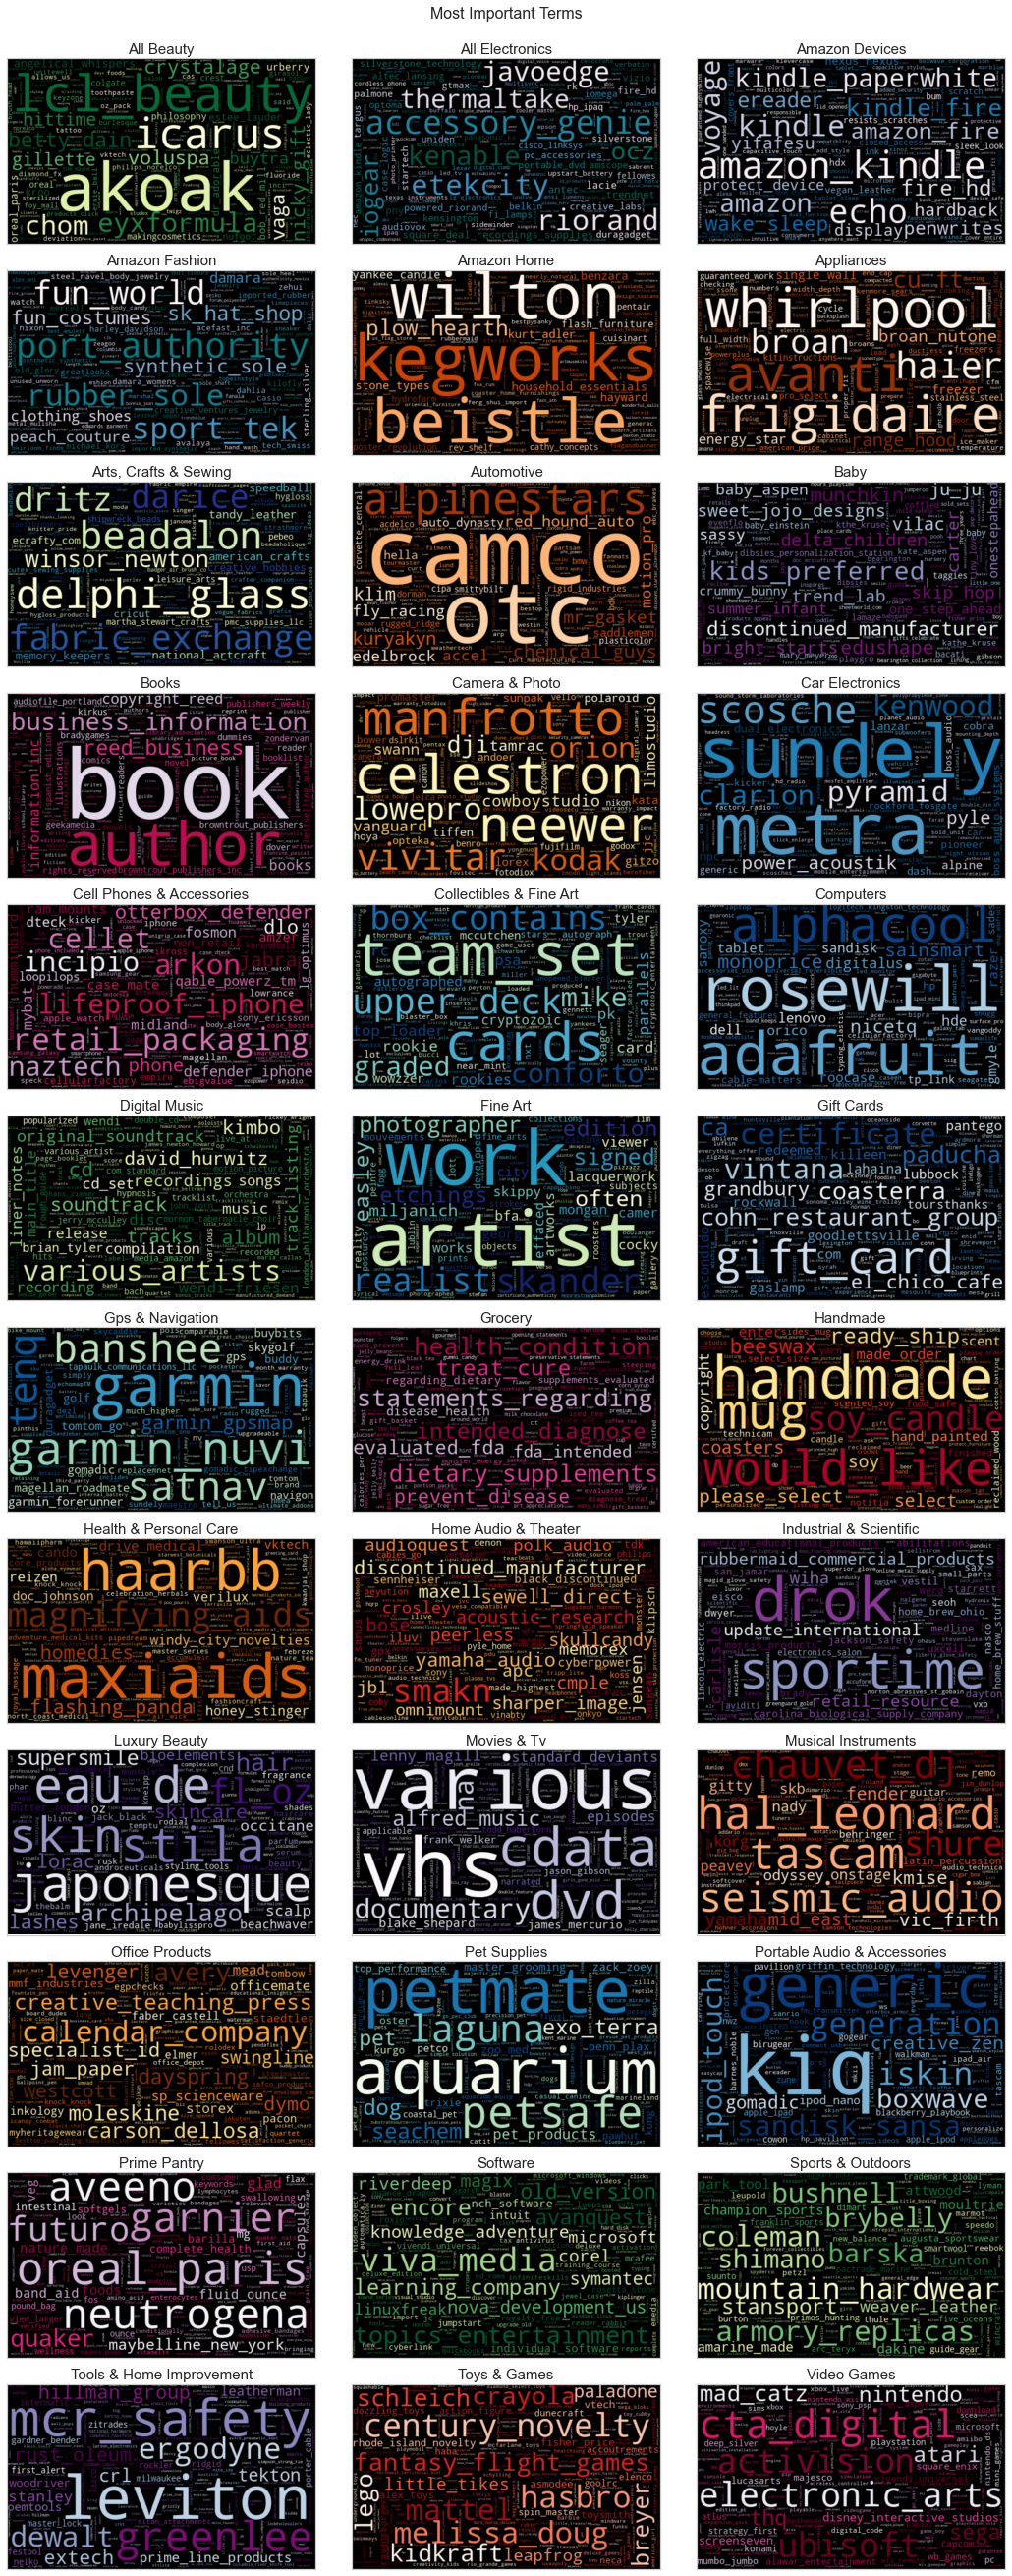

<IPython.core.display.Javascript object>

In [29]:
fig = plotting.wordcloud(
    coef,
    cmap=cmaps,
)
fig.suptitle("Most Important Terms", y=1.01, fontsize=16)
fig.savefig("figures/final_refit_coef.svg", bbox_inches="tight")

In [91]:
ngrams = [tuple(w.split("_")) for w in pipe["vec"].vocabulary_.keys() if "_" in w]
max(map(len, ngrams))

7

<IPython.core.display.Javascript object>

In [92]:
if not isinstance(pipe.steps[0], FreqVectorizer):
    fv = FreqVectorizer.from_sklearn(pipe["vec"])
    pipe.steps[0] = ("vec", fv)
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, ngram_range=(1, 7), norm='l2',
                                stop_words={'about', 'above', 'address',
                                            'addresses', 'after', 'again',
                                            'against', 'ain', 'all', 'am', 'an',
                                            'and', 'any', 'apo', 'are', 'aren',
                                            'as', 'asin', 'be', 'because',
                                            'been', 'before', 'being', 'below',
                                            'between', 'both', 'but', 'by',
                                            'can', 'couldn', ...},
                                strip_accents='ascii', strip_html_tags=True,
                                strip_punct='_',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                uniq_char_thresh=0.375, use_idf=True)),
                ('cls',

<IPython.core.display.Javascript object>

In [95]:
stop_words = set(pd.read_json("data/stopwords.json", typ="series"))
pprint(stop_words, compact=True)

{'about', 'above', 'address', 'addresses', 'after', 'again', 'against', 'ain',
 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren', 'as', 'asin', 'be',
 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by',
 'can', 'couldn', 'customer', 'did', 'didn', 'dimensions', 'do', 'does',
 'doesn', 'doing', 'don', 'down', 'during', 'each', 'eligible', 'few', 'for',
 'fpo', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven',
 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
 'how', 'if', 'in', 'inches', 'into', 'is', 'isn', 'it', 'item', 'its',
 'itself', 'just', 'listed', 'll', 'ma', 'me', 'mightn', 'more', 'most',
 'mustn', 'my', 'myself', 'needn', 'no', 'none', 'nor', 'not', 'now', 'of',
 'off', 'on', 'once', 'only', 'or', 'other', 'ounces', 'our', 'ours',
 'ourselves', 'out', 'over', 'own', 'package', 'pounds', 'product', 're',
 'review', 'reviewed', 'reviewer', 'reviews', 'same', 'shan', 'she',
 'shipments', 'shipped', 'ship

<IPython.core.display.Javascript object>

In [96]:
pipe["vec"].set_params(
    lowercase=True,
    stop_words=stop_words,
    strip_accents="ascii",
    strip_html_tags=True,
    strip_punct="_",
    uniq_char_thresh=0.375,
    token_pattern="(?i)\\b[a-z_]{2,16}\\b",
    ngram_range=(1, 7),
)

FreqVectorizer(binary=True, ngram_range=(1, 7), norm='l2',
               stop_words={'about', 'above', 'address', 'addresses', 'after',
                           'again', 'against', 'ain', 'all', 'am', 'an', 'and',
                           'any', 'apo', 'are', 'aren', 'as', 'asin', 'be',
                           'because', 'been', 'before', 'being', 'below',
                           'between', 'both', 'but', 'by', 'can', 'couldn', ...},
               strip_accents='ascii', strip_html_tags=True, strip_punct='_',
               token_pattern='(?i)\\b[a-z_]{2,16}\\b', uniq_char_thresh=0.375,
               use_idf=True)

<IPython.core.display.Javascript object>

In [97]:
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, ngram_range=(1, 7), norm='l2',
                                stop_words={'about', 'above', 'address',
                                            'addresses', 'after', 'again',
                                            'against', 'ain', 'all', 'am', 'an',
                                            'and', 'any', 'apo', 'are', 'aren',
                                            'as', 'asin', 'be', 'because',
                                            'been', 'before', 'being', 'below',
                                            'between', 'both', 'but', 'by',
                                            'can', 'couldn', ...},
                                strip_accents='ascii', strip_html_tags=True,
                                strip_punct='_',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                uniq_char_thresh=0.375, use_idf=True)),
                ('cls',

<IPython.core.display.Javascript object>

In [90]:
joblib.dump(pipe, "models/final_deploy.joblib", compress=("lz4", 3))

['models/final_deploy.joblib']

<IPython.core.display.Javascript object>